# Model - CIC IoT 2023 Dataset for Cybersecurity Research

[University of New Brunswick - Canadian Institute for Cybersecurity](https://www.unb.ca/cic/datasets/index.html)

# Imports

In [1]:
import os
import sys
import datetime

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

from IPython.display import HTML

sys.path.append('../')
n_jobs = 20

In [2]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split, GridSearchCV

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from lightgbm import LGBMClassifier

## Definitions

In [3]:
import utils
import model_utils
import visualization as viz

from multi_stage_classifier import MultiStageClassifier, ModelStage

constants = utils.get_constants()
seed = constants['seed']

train_parquet_path = constants['train_parquet_path']

features = constants['features']
protocol_layer = constants['protocol_layer']
protocol_layer_map = constants['protocol_layer_map']
attack_category = constants['attack_category']
attack_category_map = constants['attack_category_map']

## Read datasets

In [16]:
df = pd.read_parquet(train_parquet_path)

features_list = utils.get_features_list(df)
print(features_list)

FileNotFoundError: [Errno 2] No such file or directory: '/var/fasttmp/dsn/unb_cic_ds_train.parquet'

# Model (2 Stages)

In [4]:
simplified_first_layer_labels = {'DDoS', 'DoS', 'Mirai'}
simplified_second_layer_labels = {'Spoofing', 'Recon', 'Web', 'BruteForce'}

first_layer_labels = {
    attack_type
    for layer_attack in simplified_first_layer_labels
    for attack_type in attack_category[layer_attack]
}

second_layer_labels = {
    attack_type
    for layer_attack in simplified_second_layer_labels
    for attack_type in attack_category[layer_attack]
}

## First Stage - DDoS / DoS / Mirai

Here we focus on recall... **TODO: Explain why**

### 33+1 Attacks

In [ ]:
%%time

first_stage_labels = (
    df.label
    .where(df.label.isin(first_layer_labels), 'BenignTraffic')
    .astype('category')
    .cat.remove_unused_categories()
)

first_stage_df_split = model_utils.get_train_test_split(
    df,
    target=first_stage_labels,
    sample_size=10_000_000,
    train_frac=0.80
)

Training dataset size: 8.0M (80.0%).
Test dataset size: 2.0M (20.0%).
CPU times: user 22.9 s, sys: 3.82 s, total: 26.7 s
Wall time: 26.3 s


#### Search Hyperparameters

In [ ]:
%%time

simplified_first_stage_model = DecisionTreeClassifier(
    criterion='entropy',
    class_weight='balanced',
    random_state=seed
)

param_grid = {
    'min_samples_split': range(2, 11),
}

grid_search = GridSearchCV(
    estimator=simplified_first_stage_model,
    param_grid=param_grid,
    cv=4,
    n_jobs=n_jobs,
    verbose=1
)

X_train, X_test, y_train, y_test = first_stage_df_split
grid_search.fit(X_train, y_train)

print(f"Best Parameters: {grid_search.best_params_}")
print(f"Best Cross-Validation Score: {grid_search.best_score_}")

Fitting 4 folds for each of 9 candidates, totalling 36 fits
Best Parameters: {'min_samples_split': 5}
Best Cross-Validation Score: 0.9998603749999999
CPU times: user 3min 56s, sys: 7.94 s, total: 4min 4s
Wall time: 7min 24s


#### 1st Stage Model

Execution time (Model fit): 0:03:26.038867
Execution time (Predict): 0:00:00.850624
                         precision    recall  f1-score   support

          BenignTraffic     0.9999    0.9998    0.9998     84809
 DDoS-ACK_Fragmentation     0.9997    0.9993    0.9995     12226
        DDoS-HTTP_Flood     0.9976    0.9984    0.9980      1228
        DDoS-ICMP_Flood     1.0000    1.0000    1.0000    308346
DDoS-ICMP_Fragmentation     0.9993    0.9997    0.9995     19339
      DDoS-PSHACK_Flood     1.0000    1.0000    1.0000    175238
       DDoS-RSTFINFlood     1.0000    1.0000    1.0000    173031
         DDoS-SYN_Flood     0.9999    0.9999    0.9999    173993
         DDoS-SlowLoris     0.9941    0.9941    0.9941      1011
DDoS-SynonymousIP_Flood     0.9999    0.9998    0.9998    154251
         DDoS-TCP_Flood     1.0000    1.0000    1.0000    193156
         DDoS-UDP_Flood     0.9998    0.9998    0.9998    232493
 DDoS-UDP_Fragmentation     0.9994    0.9999    0.9997     12213
     

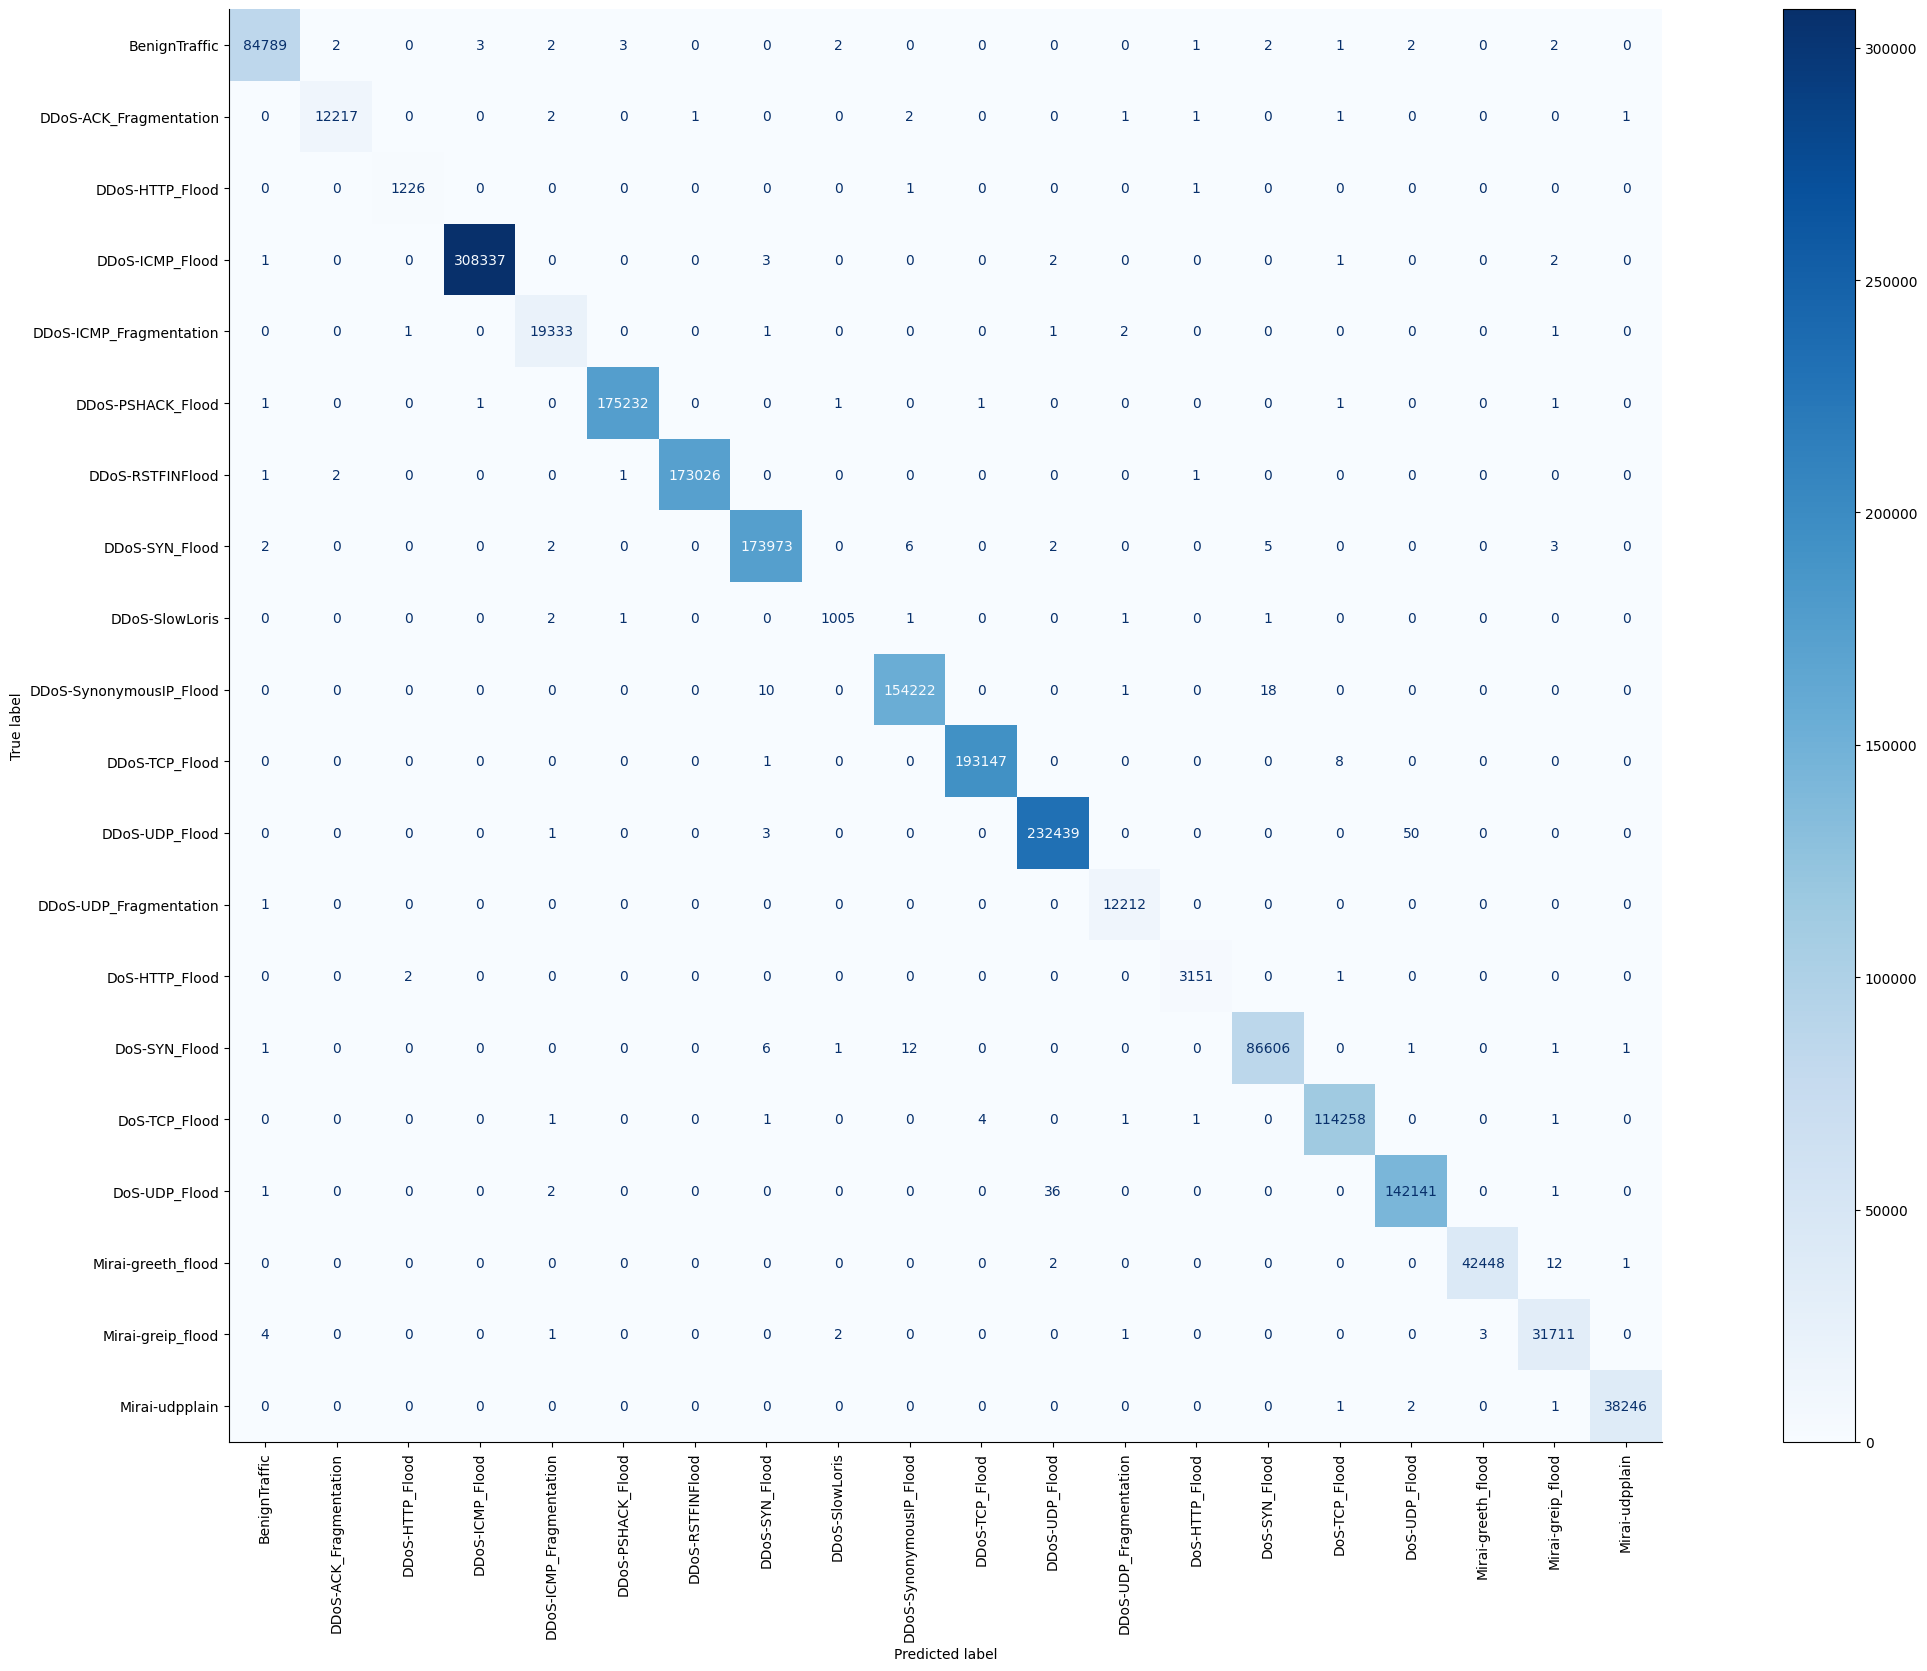

In [ ]:
%%time

first_stage_model = DecisionTreeClassifier(
    criterion='entropy',
    class_weight='balanced',
    min_samples_split=5,
    random_state=seed
)

X_train, X_test, y_train, y_test = first_stage_df_split

model_utils.train_model(first_stage_model, X_train, y_train)
model_utils.evaluate_model(first_stage_model, X_test, y_test)

### 7+1 Attacks

In [ ]:
%%time

simplified_first_stage_labels = (
    df.general_label
    .where(df.general_label.isin(simplified_first_layer_labels), 'Benign')
    .astype('category')
    .cat.remove_unused_categories()
)

simplified_first_stage_df_split = model_utils.get_train_test_split(
    df,
    target=simplified_first_stage_labels,
    sample_size=10_000_000,
    train_frac=0.80
)

Training dataset size: 8.0M (80.0%).
Test dataset size: 2.0M (20.0%).
CPU times: user 28.9 s, sys: 3.7 s, total: 32.6 s
Wall time: 32.6 s


Execution time (Model fit): 0:02:46.818262
Execution time (Predict): 0:00:00.662407
              precision    recall  f1-score   support

      Benign     0.9999    0.9999    0.9999     84362
        DDoS     1.0000    0.9999    0.9999   1455592
         DoS     0.9998    0.9998    0.9998    347105
       Mirai     0.9999    1.0000    0.9999    112941

    accuracy                         0.9999   2000000
   macro avg     0.9999    0.9999    0.9999   2000000
weighted avg     0.9999    0.9999    0.9999   2000000

CPU times: user 2min 57s, sys: 2.26 s, total: 2min 59s
Wall time: 2min 59s


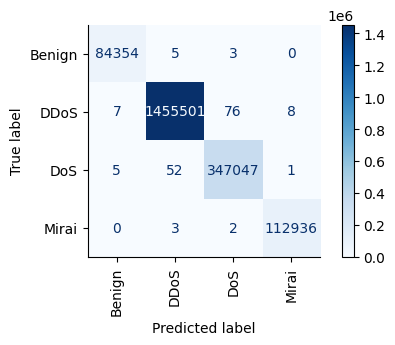

In [ ]:
%%time

simplified_first_stage_model = DecisionTreeClassifier(
    criterion='entropy',
    class_weight='balanced',
    min_samples_split=5,
    random_state=seed
)

X_train, X_test, y_train, y_test = simplified_first_stage_df_split

model_utils.train_model(simplified_first_stage_model, X_train, y_train)
model_utils.evaluate_model(simplified_first_stage_model, X_test, y_test)

## Second Stage - Spoofing / Recon / Web / Brute Force

In [5]:
# df_second_stage = df[~df.general_label.isin(simplified_first_layer_labels)]
df_second_stage = pd.read_parquet('/var/tmp/unb_cic_ds_train_second_stage.parquet')

### 33 + 1 Attacks

In [6]:
%%time

second_stage_target = (
    df_second_stage.label
    .where(df_second_stage.label.isin(second_layer_labels), 'BenignTraffic')
    .astype('category')
    .cat.remove_unused_categories()
)

second_stage_df_split = model_utils.get_train_test_split(
    df_second_stage,
    target=second_stage_target,
    train_frac=0.80
)

Training dataset size: 1.3M (80.0%).
Test dataset size: 316.3k (20.0%).
CPU times: user 176 ms, sys: 34.1 ms, total: 210 ms
Wall time: 209 ms


Execution time (Model fit): 0:02:07.671272
Execution time (Predict): 0:00:00.771803
                      precision    recall  f1-score   support

    Backdoor_Malware     0.9020    0.5702    0.6987       484
       BenignTraffic     0.9157    0.9880    0.9505    175701
    BrowserHijacking     0.9535    0.6232    0.7538       921
    CommandInjection     0.9707    0.6367    0.7690       834
        DNS_Spoofing     0.8614    0.7993    0.8292     28613
DictionaryBruteForce     0.9429    0.6316    0.7564      2090
    MITM-ArpSpoofing     0.9433    0.8687    0.9045     49320
 Recon-HostDiscovery     0.8747    0.8926    0.8835     21530
        Recon-OSScan     0.8832    0.6671    0.7601     15797
     Recon-PingSweep     0.9353    0.5494    0.6922       395
      Recon-PortScan     0.8494    0.7072    0.7718     13147
        SqlInjection     0.9220    0.5854    0.7161       808
   VulnerabilityScan     0.9386    0.5459    0.6903       196
                 XSS     1.0000    0.9997    0.

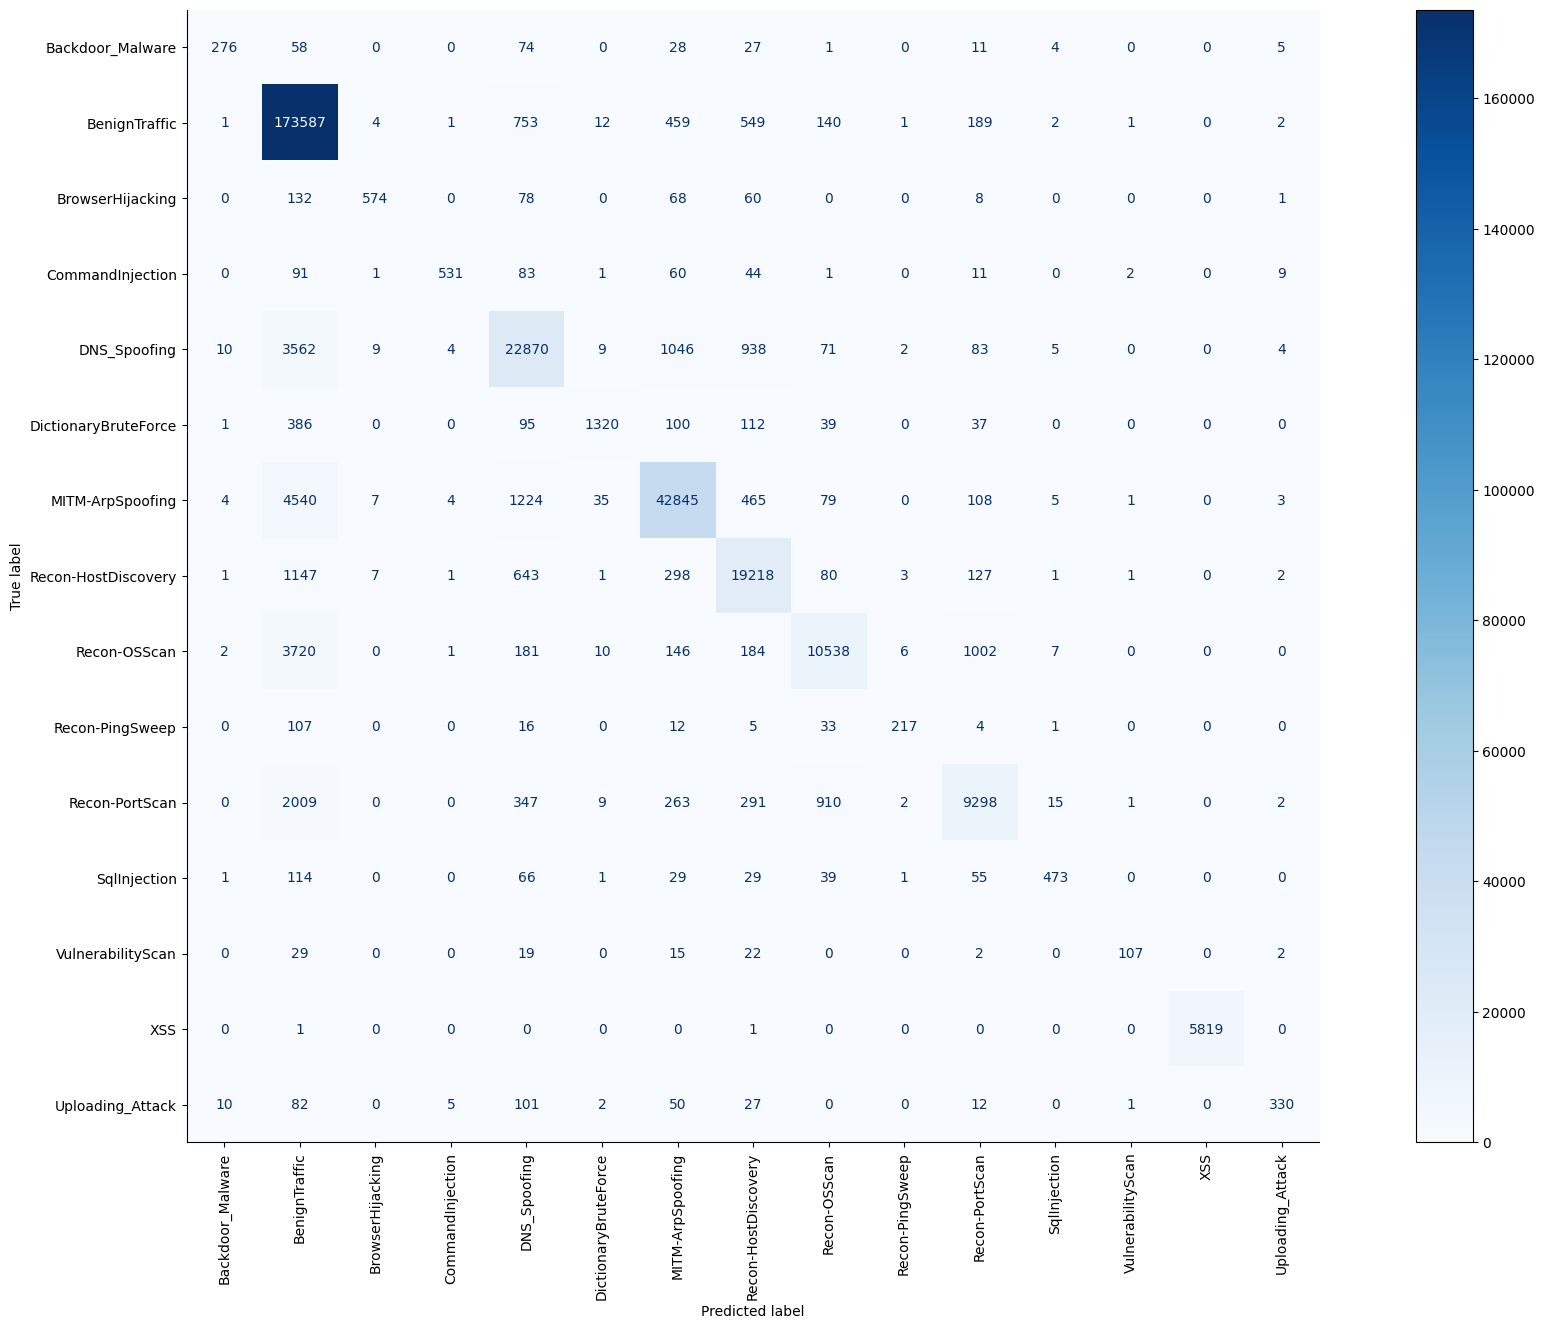

In [ ]:
%%time

second_stage_model = RandomForestClassifier(
    criterion='entropy',
    class_weight='balanced',
    bootstrap=False,
    max_features=14,
    n_jobs=n_jobs,
    random_state=seed
)

X_train, X_test, y_train, y_test = second_stage_df_split

model_utils.train_model(second_stage_model, X_train, y_train)
model_utils.evaluate_model(second_stage_model, X_test, y_test)

### 7 + 1 Attacks

In [ ]:
%%time

simplified_second_layer_target = (
    df_second_stage.general_label
    .where(df_second_stage.general_label.isin(simplified_second_layer_labels), 'Benign')
    .astype('category')
    .cat.remove_unused_categories()
)

simplified_second_stage_df_split = model_utils.get_train_test_split(
    df_second_stage,
    target=simplified_second_layer_target,
    train_frac=0.80
)

Training dataset size: 1.3M (80.0%).
Test dataset size: 316.3k (20.0%).
CPU times: user 1.2 s, sys: 59.6 ms, total: 1.26 s
Wall time: 1.26 s


Execution time (Model fit): 0:03:07.780148
Execution time (Predict): 0:00:01.023052
              precision    recall  f1-score   support

      Benign     0.9327    0.9807    0.9561    175701
  BruteForce     0.9600    0.6311    0.7615      2090
       Recon     0.9193    0.8687    0.8933     56690
    Spoofing     0.9332    0.8875    0.9098     77933
         Web     0.9484    0.6094    0.7420      3863

    accuracy                         0.9308    316277
   macro avg     0.9387    0.7955    0.8525    316277
weighted avg     0.9308    0.9308    0.9308    316277

CPU times: user 1h 36min 52s, sys: 4.3 s, total: 1h 36min 57s
Wall time: 3min 10s


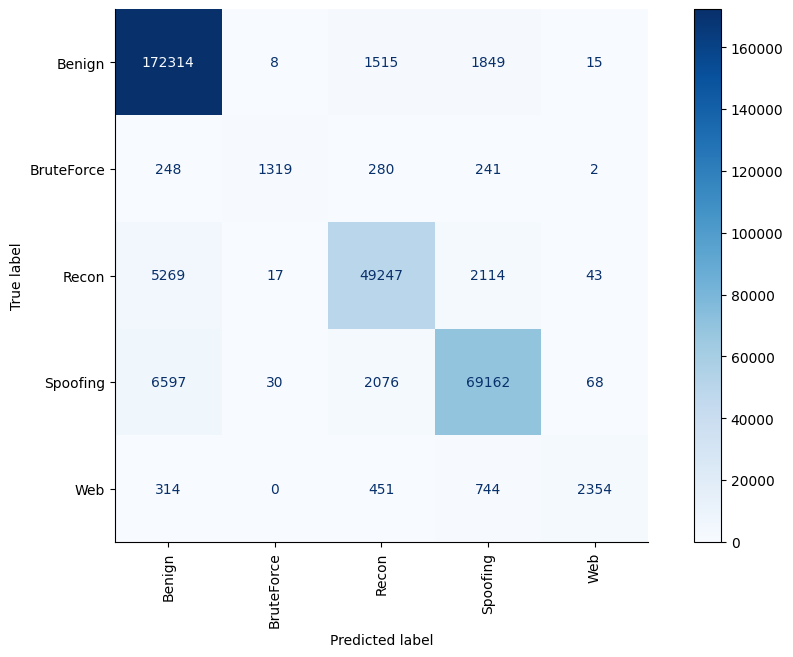

In [ ]:
%%time

simplified_second_stage_model = RandomForestClassifier(
    class_weight='balanced',
    criterion='entropy',
    bootstrap=False,
    max_features=14,
    n_jobs=n_jobs,
    random_state=seed
)

X_train, X_test, y_train, y_test = simplified_second_stage_df_split

model_utils.train_model(simplified_second_stage_model, X_train, y_train)
model_utils.evaluate_model(simplified_second_stage_model, X_test, y_test)

# Multi-Stage Model

### 33+1 Attacks

In [ ]:
%%time

multi_stage_df_split = model_utils.get_train_test_split(
    df,
    target='label',
    sample_size=10_000_000,
    train_frac=0.80
)

Training dataset size: 8.0M (80.0%).
Test dataset size: 2.0M (20.0%).
CPU times: user 22 s, sys: 2.85 s, total: 24.9 s
Wall time: 24.9 s


Execution time (Model fit): 0:04:48.417315
Execution time (Predict): 0:00:03.076922
                         precision    recall  f1-score   support

       Backdoor_Malware     0.9508    0.4462    0.6073       130
          BenignTraffic     0.9037    0.9878    0.9439     47244
       BrowserHijacking     0.9503    0.6169    0.7482       248
       CommandInjection     0.9220    0.5909    0.7202       220
 DDoS-ACK_Fragmentation     0.9994    0.9996    0.9995     12153
        DDoS-HTTP_Flood     1.0000    0.9959    0.9980      1234
        DDoS-ICMP_Flood     1.0000    1.0000    1.0000    308370
DDoS-ICMP_Fragmentation     0.9997    0.9995    0.9996     19369
      DDoS-PSHACK_Flood     1.0000    1.0000    1.0000    175426
       DDoS-RSTFINFlood     1.0000    1.0000    1.0000    173488
         DDoS-SYN_Flood     0.9999    0.9999    0.9999    174310
         DDoS-SlowLoris     0.9980    0.9980    0.9980       989
DDoS-SynonymousIP_Flood     0.9998    0.9999    0.9999    154049
     

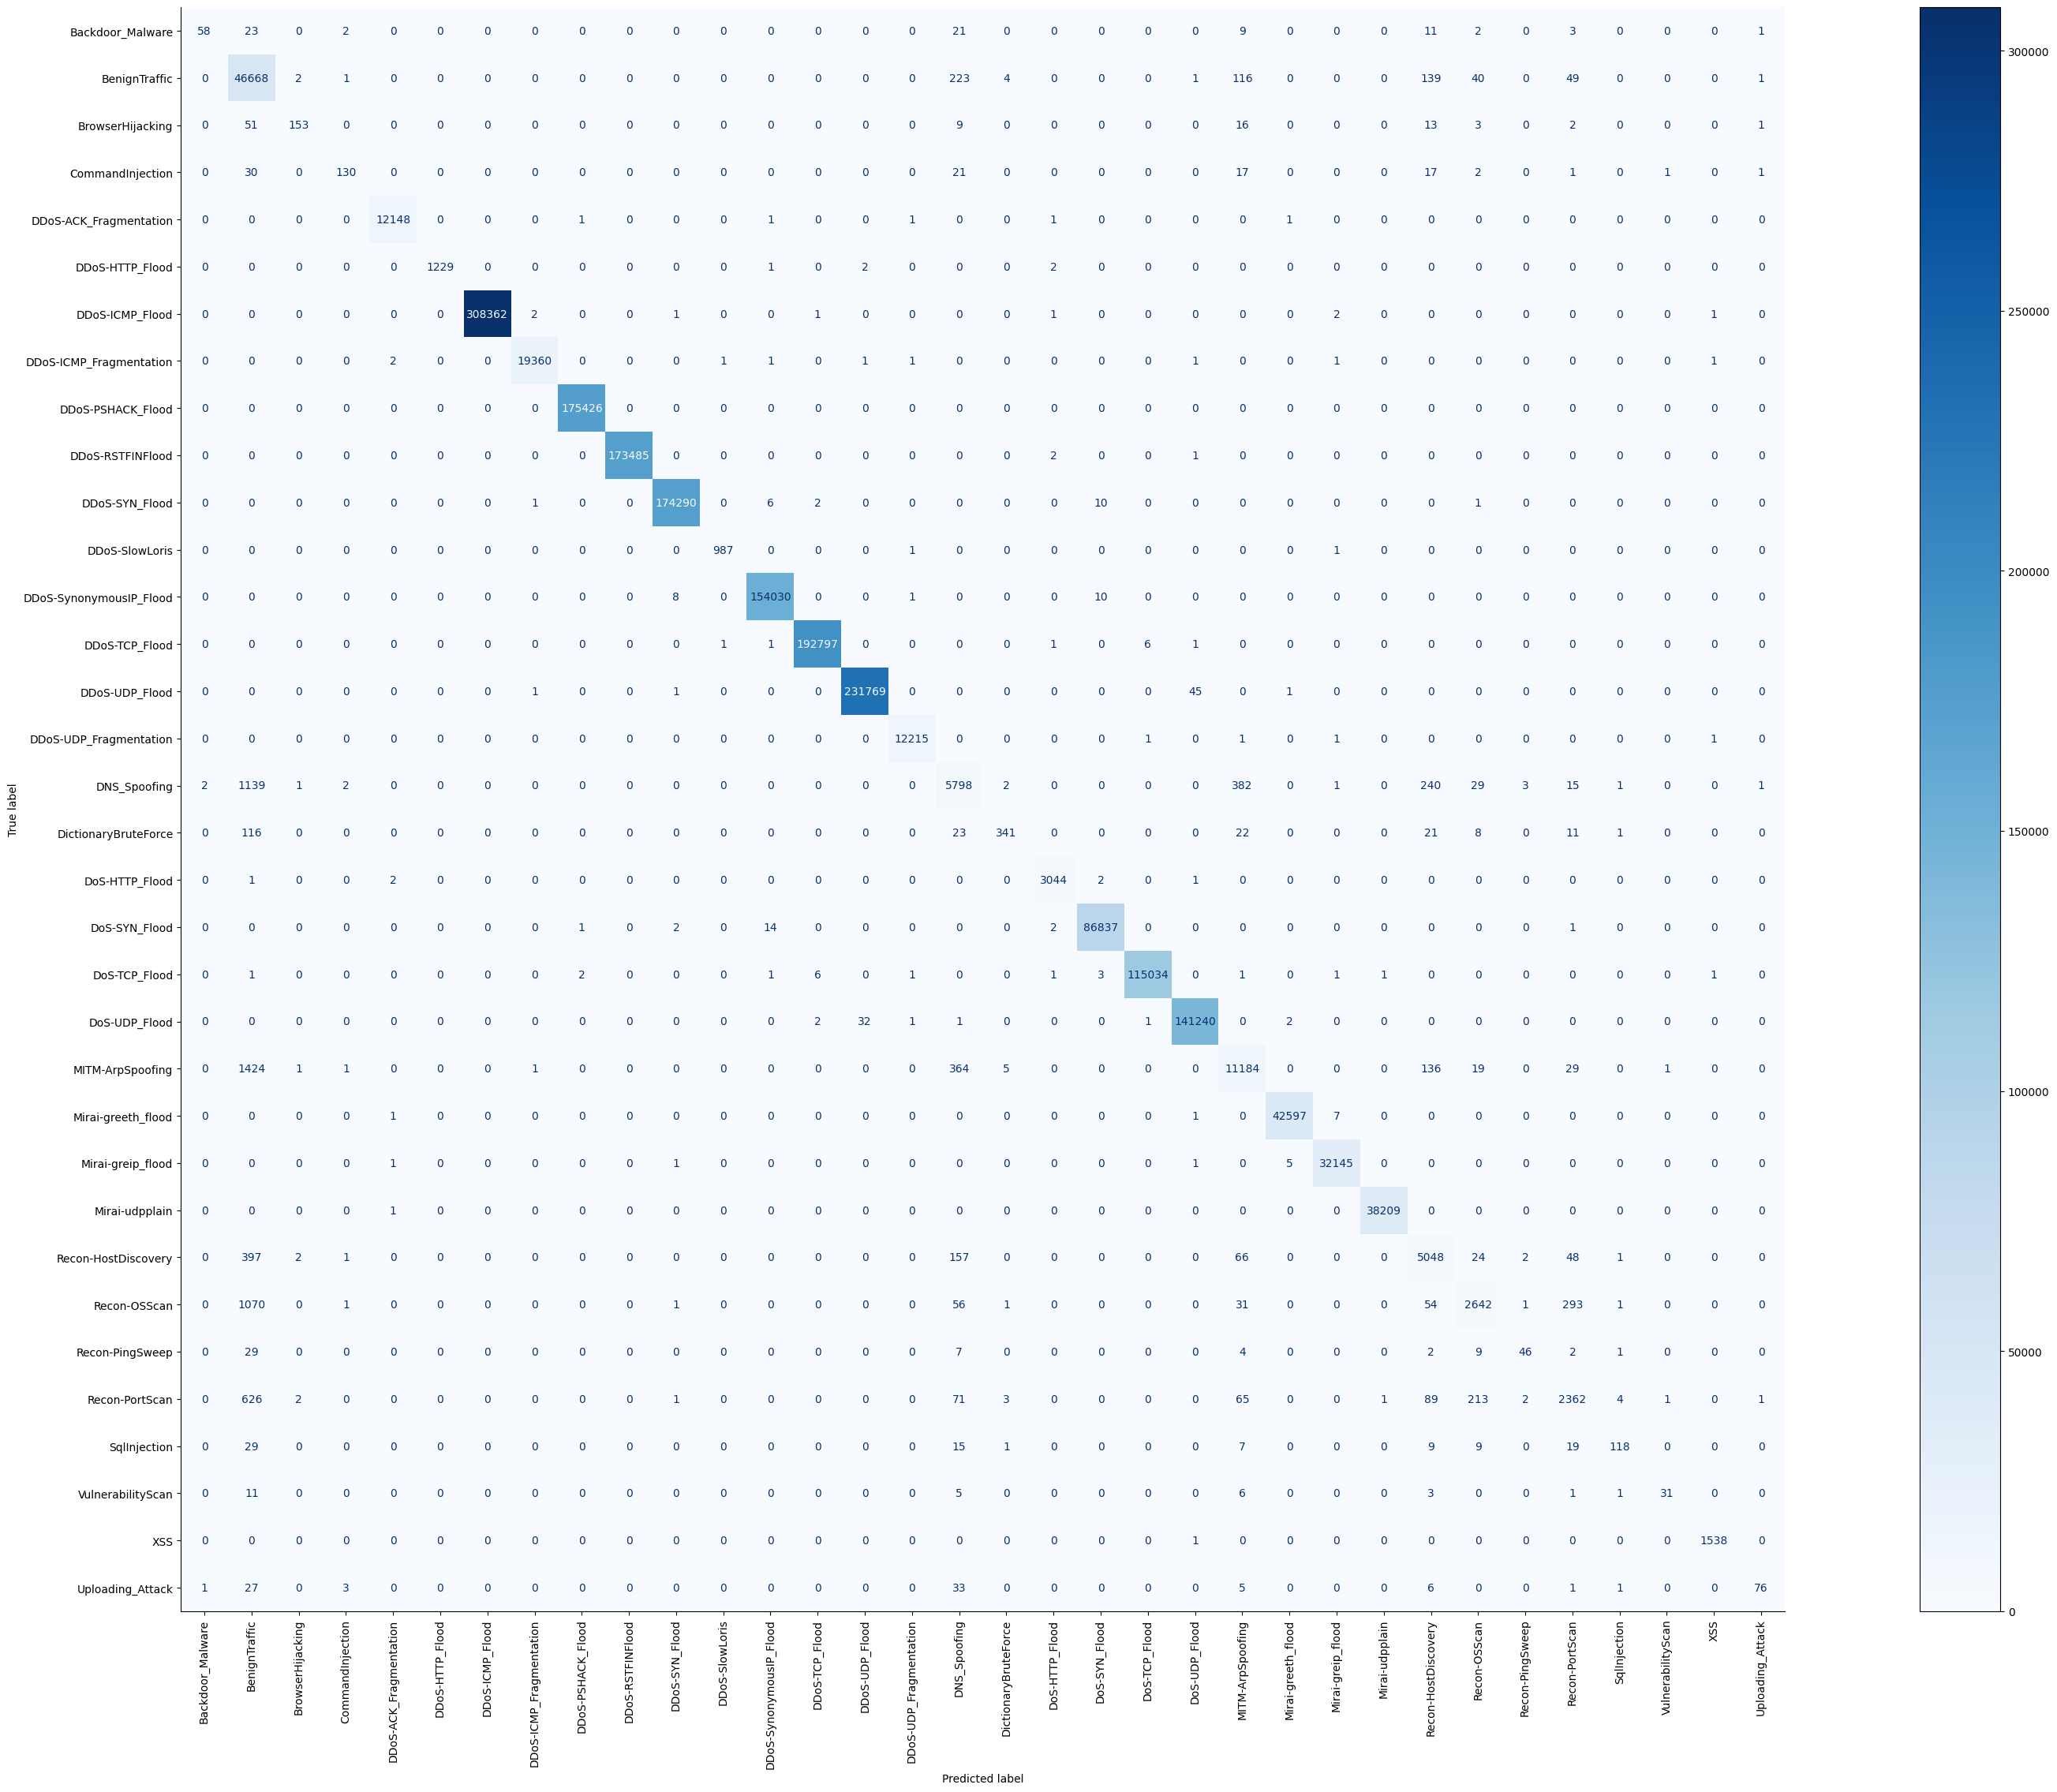

In [ ]:
%%time
multi_stage_baseline_model = MultiStageClassifier(
    stages=[
        ModelStage(first_stage_model, labels=first_layer_labels),
        ModelStage(second_stage_model, labels=second_layer_labels),
    ],
    default_label='BenignTraffic'
)

X_train, X_test, y_train, y_test = multi_stage_df_split

model_utils.train_model(multi_stage_baseline_model, X_train, y_train)
model_utils.evaluate_model(multi_stage_baseline_model, X_test, y_test)

### 7+1 Attacks

In [ ]:
%%time

simplified_multi_stage_df_split = model_utils.get_train_test_split(
    df,
    target='general_label',
    sample_size=10_000_000,
    train_frac=0.80
)

Training dataset size: 8.0M (80.0%).
Test dataset size: 2.0M (20.0%).
CPU times: user 21.4 s, sys: 2.3 s, total: 23.7 s
Wall time: 23.6 s


Execution time (Model fit): 0:03:51.894796
Execution time (Predict): 0:00:01.788057
              precision    recall  f1-score   support

      Benign     0.9271    0.9782    0.9520     47054
  BruteForce     0.9463    0.5959    0.7313       532
        DDoS     1.0000    0.9999    0.9999   1455692
         DoS     0.9997    0.9998    0.9998    346545
       Mirai     0.9999    1.0000    0.9999    113285
       Recon     0.9105    0.8593    0.8841     15112
    Spoofing     0.9272    0.8768    0.9013     20707
         Web     0.9498    0.5815    0.7214      1073

    accuracy                         0.9967   2000000
   macro avg     0.9575    0.8614    0.8987   2000000
weighted avg     0.9967    0.9967    0.9967   2000000

CPU times: user 25min 11s, sys: 3.69 s, total: 25min 15s
Wall time: 4min 6s


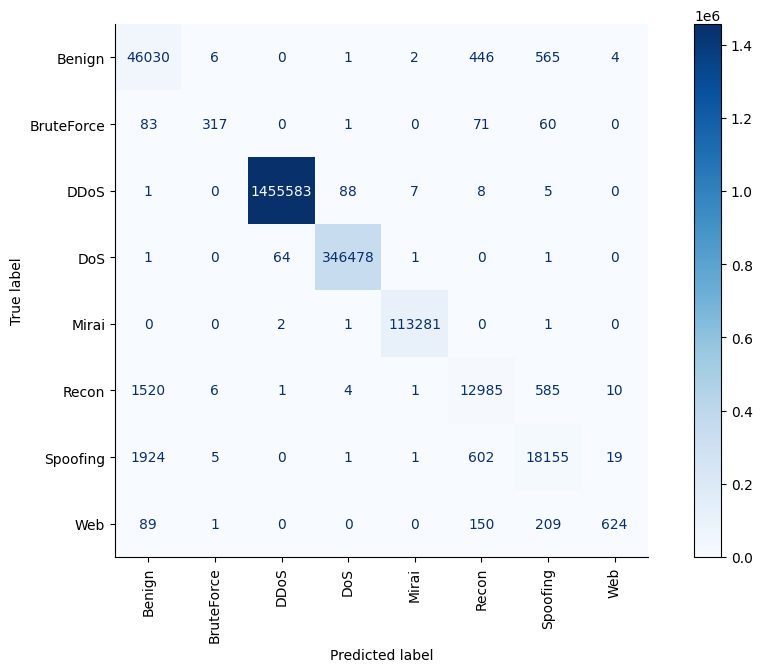

In [ ]:
%%time
simplified_multi_stage_baseline_model = MultiStageClassifier(
    stages=[
        ModelStage(simplified_first_stage_model, labels=simplified_first_layer_labels),
        ModelStage(simplified_second_stage_model, labels=simplified_second_layer_labels),
    ]
)

X_train, X_test, y_train, y_test = simplified_multi_stage_df_split

model_utils.train_model(simplified_multi_stage_baseline_model, X_train, y_train)
model_utils.evaluate_model(simplified_multi_stage_baseline_model, X_test, y_test)

# Open questions from the EDA

## Simple baseline

In [ ]:
%%time

test_df_split = model_utils.get_train_test_split(
    df,
    target='general_label',
    sample_size=5_000_000,
    train_frac=0.80
)

Training dataset size: 4.0M (80.0%).
Test dataset size: 1.0M (20.0%).
CPU times: user 15 s, sys: 4.28 s, total: 19.3 s
Wall time: 19.3 s


Execution time (Model fit): 0:01:26.064270
Execution time (Predict): 0:00:02.862032
              precision    recall  f1-score   support

      Benign     0.9153    0.9753    0.9444     23650
  BruteForce     0.9930    0.4846    0.6514       293
        DDoS     0.9998    1.0000    0.9999    726946
         DoS     0.9998    0.9997    0.9998    174022
       Mirai     0.9999    0.9999    0.9999     56700
       Recon     0.8906    0.8114    0.8491      7485
    Spoofing     0.8948    0.8574    0.8757     10349
         Web     0.9774    0.3117    0.4727       555

    accuracy                         0.9959   1000000
   macro avg     0.9588    0.8050    0.8491   1000000
weighted avg     0.9959    0.9959    0.9959   1000000

CPU times: user 37min 22s, sys: 18.3 s, total: 37min 41s
Wall time: 1min 34s


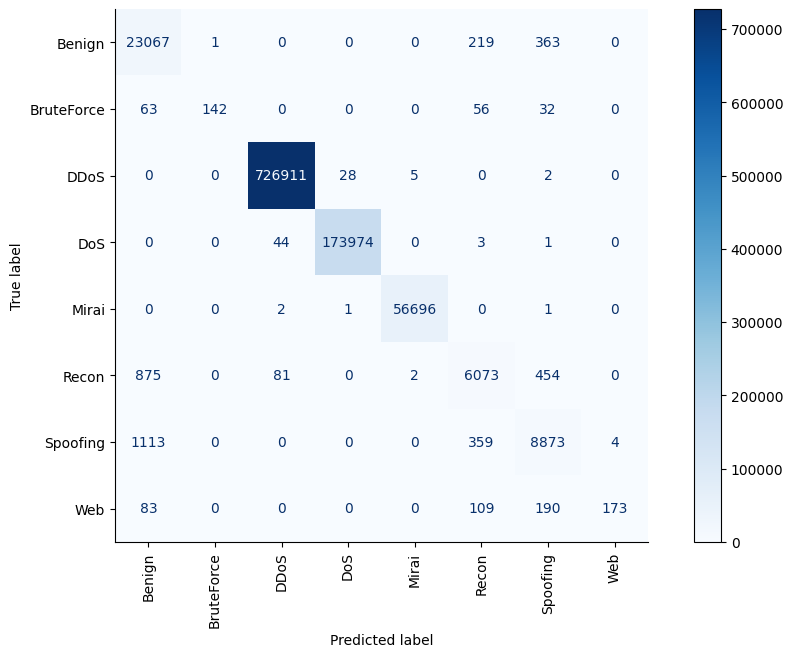

In [ ]:
%%time

test_model = RandomForestClassifier(
    n_jobs=n_jobs,
    random_state=seed
)

X_train, X_test, y_train, y_test = test_df_split

model_utils.train_model(test_model, X_train, y_train)
model_utils.evaluate_model(test_model, X_test, y_test)

### Model without duplicates

In [ ]:
%%time

test_df_split = model_utils.get_train_test_split(
    df.drop_duplicates(),
    target='general_label',
    sample_size=5_000_000,
    train_frac=0.80
)

Training dataset size: 4.0M (80.0%).
Test dataset size: 1.0M (20.0%).
CPU times: user 4min 36s, sys: 31.4 s, total: 5min 7s
Wall time: 5min 7s


Execution time (Model fit): 0:01:49.125567
Execution time (Predict): 0:00:02.886750
              precision    recall  f1-score   support

      Benign     0.9152    0.9774    0.9453     39064
  BruteForce     1.0000    0.4793    0.6480       434
        DDoS     0.9997    0.9999    0.9998    625356
         DoS     0.9998    0.9997    0.9997    229134
       Mirai     0.9999    0.9999    0.9999     75332
       Recon     0.8966    0.8218    0.8576     12443
    Spoofing     0.9070    0.8596    0.8827     17351
         Web     0.9735    0.3318    0.4949       886

    accuracy                         0.9935   1000000
   macro avg     0.9615    0.8087    0.8535   1000000
weighted avg     0.9935    0.9935    0.9935   1000000

CPU times: user 48min 4s, sys: 12.5 s, total: 48min 16s
Wall time: 1min 57s


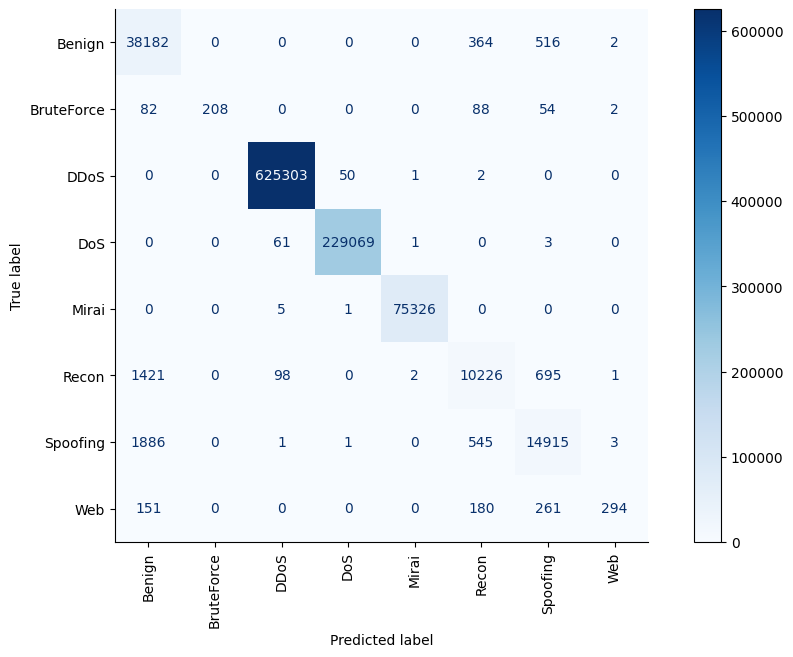

In [ ]:
%%time

test_model = RandomForestClassifier(
    n_jobs=n_jobs,
    random_state=seed
)

X_train, X_test, y_train, y_test = test_df_split

model_utils.train_model(test_model, X_train, y_train)
model_utils.evaluate_model(test_model, X_test, y_test)

### Model without IAT

In [ ]:
%%time

test_df_split = model_utils.get_train_test_split(
    df.drop(columns=['IAT']),
    target='general_label',
    sample_size=5_000_000,
    train_frac=0.80
)

Training dataset size: 4.0M (80.0%).
Test dataset size: 1.0M (20.0%).
CPU times: user 18.9 s, sys: 6.47 s, total: 25.3 s
Wall time: 25.3 s


Execution time (Model fit): 0:02:22.128800
Execution time (Predict): 0:00:05.881777
              precision    recall  f1-score   support

      Benign     0.8426    0.9542    0.8949     23710
  BruteForce     0.9286    0.1403    0.2437       278
        DDoS     0.9387    0.9582    0.9484    728000
         DoS     0.8079    0.7379    0.7713    172993
       Mirai     0.9993    0.9959    0.9976     56534
       Recon     0.7734    0.6749    0.7208      7453
    Spoofing     0.8288    0.7125    0.7663     10509
         Web     0.9767    0.0803    0.1484       523

    accuracy                         0.9168   1000000
   macro avg     0.8870    0.6568    0.6864   1000000
weighted avg     0.9168    0.9168    0.9168   1000000

CPU times: user 1h 3min 27s, sys: 18.5 s, total: 1h 3min 46s
Wall time: 2min 34s


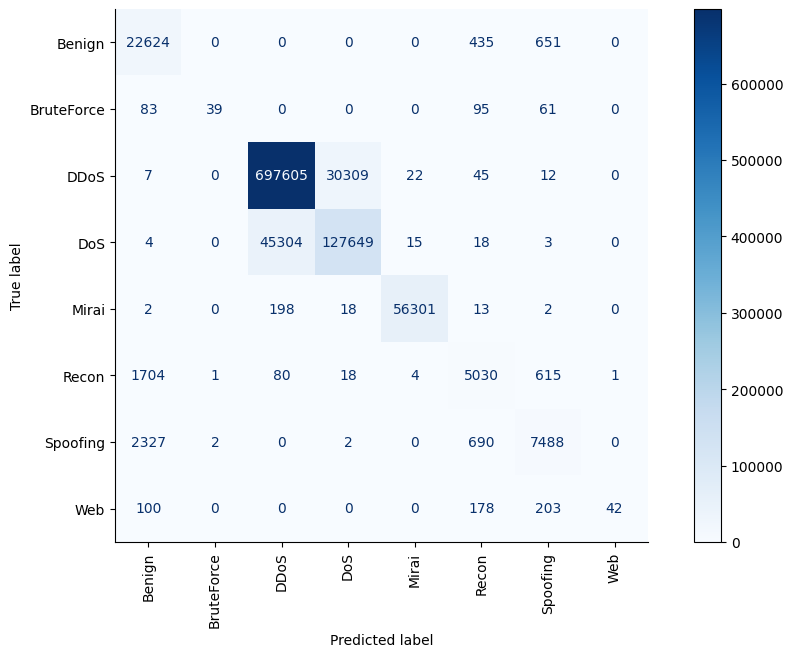

In [ ]:
%%time

test_model = RandomForestClassifier(
    n_jobs=n_jobs,
    random_state=seed
)

X_train, X_test, y_train, y_test = test_df_split

model_utils.train_model(test_model, X_train, y_train)
model_utils.evaluate_model(test_model, X_test, y_test)